In [126]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB         # Naive Bayes
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob, Word
import nltk

%matplotlib inline

pd.set_option('display.max_columns', None)

In [127]:
data_folder='../../data/airbnb/'
#files: calendar.csv.gz  listings_summary.csv    reviews.csv.gz
# listings.csv     neighbourhoods.csv      reviews_summary.csv
# listings.csv.gz  neighbourhoods.geojson

data_calendar = pd.read_csv(data_folder+"calendar.csv")
data_listings_summary=pd.read_csv(data_folder+"listings_summary.csv")
data_reviews = pd.read_csv(data_folder+"reviews.csv.gz")
data_listings = pd.read_csv(data_folder+"listings.csv",low_memory=False, parse_dates=True)
data_neighbourhoods= pd.read_csv(data_folder+"neighbourhoods.csv", low_memory=False)
data_review_summary=pd.read_csv(data_folder+"reviews_summary.csv")
data_neighbourhoods_geo=pd.read_json(data_folder+"neighbourhoods.geojson")

In [128]:
data_listings.drop(["scrape_id","listing_url","interaction","notes","thumbnail_url","medium_url","picture_url","host_url","host_name","host_response_time","host_response_rate","host_acceptance_rate","host_thumbnail_url","host_picture_url","host_listings_count","host_verifications","host_identity_verified"],axis=1,inplace=True)
data_listings.drop(["first_review","license","jurisdiction_names","requires_license","require_guest_phone_verification"],axis=1,inplace=True)
data_listings.drop(["xl_picture_url","host_location","market","smart_location","country_code","country","is_location_exact"],axis=1,inplace=True)
data_listings.drop(["host_neighbourhood","street","square_feet","weekly_price","monthly_price","security_deposit","cleaning_fee","guests_included","review_scores_accuracy","review_scores_checkin","review_scores_communication","review_scores_value"],axis=1,inplace=True)
data_listings.drop(["neighbourhood_group_cleansed","minimum_nights_avg_ntm","maximum_nights_avg_ntm","calendar_updated","calculated_host_listings_count","calculated_host_listings_count_entire_homes","calculated_host_listings_count_private_rooms","calculated_host_listings_count_shared_rooms"],axis=1,inplace=True)
data_listings.drop(["transit","zipcode","city","state"],axis=1,inplace=True)
data_listings.drop(['maximum_nights','minimum_minimum_nights', 'maximum_minimum_nights','minimum_maximum_nights', 'maximum_maximum_nights'],axis=1,inplace=True)
data_listings.drop(["bathrooms","bedrooms","neighbourhood",'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped',"is_business_travel_ready"],axis=1,inplace=True)
data_listings.drop(["has_availability","extra_people"],axis=1,inplace=True)



Index(['id', 'last_scraped', 'name', 'summary', 'space', 'description',
       'experiences_offered', 'neighborhood_overview', 'access', 'house_rules',
       'host_id', 'host_since', 'host_about', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'beds', 'bed_type', 'amenities', 'price',
       'minimum_nights', 'number_of_reviews', 'number_of_reviews_ltm',
       'last_review', 'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_location'],
      dtype='object')

In [129]:
data_listings['price2'] = data_listings['id'].map(data_listings_summary.set_index('id')['price'])

In [130]:
data_listings['price_per_guest']=data_listings['price2']/data_listings['accommodates']

In [131]:
data_listings['price_per_guest']=np.log1p(data_listings.price_per_guest)

In [132]:
data_listings.dropna(inplace=True)

In [133]:
text_fields=['amenities','summary','space', 'description', 'experiences_offered', 'neighborhood_overview']

In [134]:
for field in text_fields:
    data_listings[field]= data_listings[field].str.replace(r'[^\x00-\x7F]+', '')

In [135]:
summary_nlp=data_listings.summary

In [136]:
X_train, X_test, y_train, y_test = train_test_split(summary_nlp, data_listings.price_per_guest, random_state=42)

In [137]:
amenities_nlp=data_listings.amenities
Xamen_train, Xamen_test, yamen_train, yamen_test = train_test_split(amenities_nlp, data_listings.price_per_guest, random_state=42)

In [190]:
data_listings['text_all']=data_listings['name']+" "+data_listings['summary']+' '+data_listings['amenities']+" "+data_listings['neighborhood_overview']

In [192]:
data_listings.text_all.head()

0    Arty and Bright London Apartment in Zone 2 Unl...
2    Holiday London DB Room Let-on going My bright ...
3    Canary Wharf Immaculate Apt for 2 The bright, ...
4    Sunny Notting Hill flat & terrace This is a ho...
5    Bright Chelsea  Apartment. Chelsea! Lots of wi...
Name: text_all, dtype: object

In [193]:
X_train, X_test, y_train, y_test = train_test_split(data_listings.text_all, data_listings.price_per_guest, random_state=42)

In [139]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\isimr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\isimr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [140]:
stemmer = PorterStemmer()
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop.append('or')
stop.append('in')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\isimr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [141]:
#X_train.reset_index().drop('index',axis=1,inplace=True)
review = X_train.values[0]

# Initialize stemmer.
stemmer = PorterStemmer()
lemma= WordNetLemmatizer()
# Stem each word.
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (lemma.lemmatize(w) for w in analyzer(doc))

stem_vectorizer = CountVectorizer(lowercase=True,stop_words=stop,analyzer=stemmed_words,min_df=3,ngram_range=(1,3))
X_train_dtm = stem_vectorizer.fit_transform(X_train)
print(X_train_dtm.shape)
print(stem_vectorizer.get_feature_names()[:20])

(13206, 5145)
['00', '000', '00am', '00pm', '02', '03rd', '10', '100', '1000', '100ft', '100m', '100mb', '10am', '10m', '10min', '10mins', '10minute', '10minutes', '10mn', '10pm']


In [142]:
X_test_dtm = stem_vectorizer.transform(X_test)

from sklearn.ensemble import RandomForestRegressor
# Use Random Forest to predict the star rating.
rf_reg = RandomForestRegressor(n_estimators=50)
rf_reg.fit(X_train_dtm, y_train)
#y_pred_class = rf_reg.predict(X_test_dtm)



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [143]:
y_pred_class = rf_reg.predict(X_test_dtm)


In [144]:
from sklearn.model_selection import cross_val_score, cross_val_predict
print(metrics.mean_squared_error(y_test,y_pred_class))

0.17658989599154545


In [27]:
cross_val_score(rf_reg,X_train_dtm,y_train)

C:\Users\isimr\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


array([0.32077194, 0.28669782, 0.30733563])

In [145]:
#amenities
stem_vectorizer = CountVectorizer(lowercase=True,stop_words=stop,analyzer=stemmed_words,min_df=3,ngram_range=(1,3))
Xamen_train_dtm = stem_vectorizer.fit_transform(Xamen_train)
print(Xamen_train_dtm.shape)
print(stem_vectorizer.get_feature_names()[:20])

(13206, 269)
['24', 'access', 'accessible', 'aid', 'air', 'alfresco', 'allowed', 'alone', 'amazon', 'and', 'area', 'around', 'baby', 'babysitter', 'backyard', 'balcony', 'bar', 'basic', 'bath', 'bathroom']


In [172]:
def tokenize_test(vect,X_train,X_test,y_train,y_test):
    X_train_dtm = vect.fit_transform(X_train)
    print(('Features: ', X_train_dtm.shape[1]))
    X_test_dtm = vect.transform(X_test)
    rf_reg = RandomForestRegressor(n_estimators=100)
    rf_reg.fit(X_train_dtm, y_train)
    y_pred_class = rf_reg.predict(X_test_dtm)
    print(('Accuracy: ', r2_score(y_test, y_pred_class)))

In [174]:
stem_vectorizer.get_feature_names()[:20]
feature_importance =pd.DataFrame({'feature':stem_vectorizer.get_feature_names(), 'importance':rf_reg.feature_importances_}).sort_values(by='importance',ascending=False)

In [176]:
feature_importance[:10]

,feature,importance
74,dryer,0.038647
105,free,0.037358
251,tv,0.030019
61,detector,0.018680
6,allowed,0.018186
178,on,0.017849
78,elevator,0.016059
213,shampoo,0.014849
199,private,0.014783
68,door,0.014196


### Tokenize summary using tfid vectorizer and save the document term matrix

In [219]:
tfid_vect=TfidfVectorizer(lowercase=True,stop_words=stop,analyzer=stemmed_words,min_df=3,ngram_range=(1,3))
rf_reg=RandomForestRegressor()
X_train_dtm = tfid_vect.fit_transform(X_train)
print(('Features: ', X_train_dtm.shape[1]))
X_test_dtm = tfid_vect.transform(X_test)
rf_reg = RandomForestRegressor(n_estimators=100)
rf_reg.fit(X_train_dtm, y_train)
y_pred_class = rf_reg.predict(X_test_dtm)
print(('Accuracy: ', r2_score(y_test, y_pred_class)))
#(tfid_vect.get_feature_names())

('Features: ', 9549)
('Accuracy: ', 0.3522388190740968)


In [220]:
feature_importance =pd.DataFrame({'feature':tfid_vect.get_feature_names(), 'importance':rf_reg.feature_importances_}).sort_values(by='importance',ascending=False)

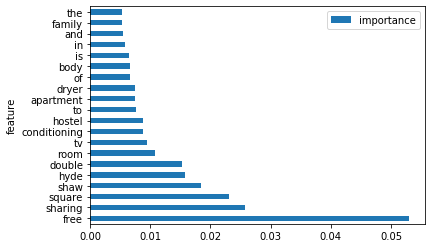

In [232]:
feature_importance[:20].plot('feature','importance',kind='barh')

In [314]:
#create mega string
text_string=""
for i in range(feature_importance.shape[0]):
    if int(1000*feature_importance.iloc[i,1])==0:
        pass
    else:
        print((feature_importance.iloc[i,0]+" ")*int(100*feature_importance.iloc[i,1]))
        text_string += (feature_importance.iloc[i,0]+" ")*int(100*feature_importance.iloc[i,1])

free free free free free 
sharing sharing 
square square 
shaw 
hyde 
double 
room 
































































































































































































































In [315]:
pd.DataFrame(tfid_vect.fit_transform(X_test).toarray(), columns=tfid_vect.get_feature_names()).max(axis=0).sort_values(ascending=False)[:20]

km             0.780571
spitafields    0.764362
farringdon     0.734582
minuet         0.714157
holland        0.712910
chiswick       0.705066
bromley        0.700529
wimbledon      0.700449
woolwich       0.693148
battersea      0.684473
teddington     0.683085
golders        0.680445
ealing         0.674203
min            0.670802
wapping        0.669685
bow            0.669408
deptford       0.667873
w12            0.664116
acton          0.663582
brixton        0.660295
dtype: float64

In [234]:
print(X_train_dtm.shape)
print(X_test_dtm.shape)

(13206, 9549)
(4402, 9549)


In [316]:
pd.DataFrame(tfid_vect.fit_transform(X_test).toarray(), columns=tfid_vect.get_feature_names())



00  000   02        10  100  1000  100m  100mb  101  10am  10min  \
0     0.0  0.0  0.0  0.055065  0.0   0.0   0.0    0.0  0.0   0.0    0.0   
1     0.0  0.0  0.0  0.040965  0.0   0.0   0.0    0.0  0.0   0.0    0.0   
2     0.0  0.0  0.0  0.064137  0.0   0.0   0.0    0.0  0.0   0.0    0.0   
3     0.0  0.0  0.0  0.000000  0.0   0.0   0.0    0.0  0.0   0.0    0.0   
4     0.0  0.0  0.0  0.000000  0.0   0.0   0.0    0.0  0.0   0.0    0.0   
...   ...  ...  ...       ...  ...   ...   ...    ...  ...   ...    ...   
4397  0.0  0.0  0.0  0.000000  0.0   0.0   0.0    0.0  0.0   0.0    0.0   
4398  0.0  0.0  0.0  0.000000  0.0   0.0   0.0    0.0  0.0   0.0    0.0   
4399  0.0  0.0  0.0  0.000000  0.0   0.0   0.0    0.0  0.0   0.0    0.0   
4400  0.0  0.0  0.0  0.000000  0.0   0.0   0.0    0.0  0.0   0.0    0.0   
4401  0.0  0.0  0.0  0.000000  0.0   0.0   0.0    0.0  0.0   0.0    0.0   

      10mins  10minute  10mn  10pm   11  11am  11m  11min  11pm  11th  \
0        0.0       0.0   0.0   0.0  0.0   0.0  0.0    0.0   0.0   0.0   
1        0.0       0.0   0.0   0.0  0.0   0.0  0.0    0.0   0.0   0.0   
2        0.0       0.0   0.0   0.0  0.0   0.0  0.0    0.0   0.0   0.0   
3        0.0       0.0   0.0   0.0  0.0   0.0  0.0    0.0   0.0   0.0   
4        0.0       0.0   0.0   0.0  0.0   0.0  0.0    0.0   0.0   0.0   
...      ...       ...   ...   ...  ...   ...  ...    ...   ...   ...   
4397     0.0       0.0   0.0   0.0  0.0   0.0  0.0    0.0   0.0   0.0   
4398     0.0       0.0   0.0   0.0  0.0   0.0  0.0    0.0   0.0   0.0   
4399     0.0       0.0   0.0   0.0  0.0   0.0  0.0    0.0   0.0   0.0   
4400     0.0       0.0   0.0   0.0  0.0   0.0  0.0    0.0   0.0   0.0   
4401     0.0       0.0   0.0   0.0  0.0   0.0  0.0    0.0   0.0   0.0   

            12  120  1200  12ft  12min  12mins   13  13min  13mins   14  140  \
0     0.000000  0.0   0.0   0.0    0.0     0.0  0.0    0.0     0.0  0.0  0.0   
1     0.000000  0.0   0.0   0.0    0.0     0.0  0.0    0.0     0.0  0.0  0.0   
2     0.000000  0.0   0.0   0.0    0.0     0.0  0.0    0.0     0.0  0.0  0.0   
3     0.000000  0.0   0.0   0.0    0.0     0.0  0.0    0.0     0.0  0.0  0.0   
4     0.000000  0.0   0.0   0.0    0.0     0.0  0.0    0.0     0.0  0.0  0.0   
...        ...  ...   ...   ...    ...     ...  ...    ...     ...  ...  ...   
4397  0.069142  0.0   0.0   0.0    0.0     0.0  0.0    0.0     0.0  0.0  0.0   
4398  0.088110  0.0   0.0   0.0    0.0     0.0  0.0    0.0     0.0  0.0  0.0   
4399  0.000000  0.0   0.0   0.0    0.0     0.0  0.0    0.0     0.0  0.0  0.0   
4400  0.000000  0.0   0.0   0.0    0.0     0.0  0.0    0.0     0.0  0.0  0.0   
4401  0.000000  0.0   0.0   0.0    0.0     0.0  0.0    0.0     0.0  0.0  0.0   

      14mins        15  150  1500  150mb  1550  15min  15mins  15minute  \
0        0.0  0.000000  0.0   0.0    0.0   0.0    0.0     0.0       0.0   
1        0.0  0.000000  0.0   0.0    0.0   0.0    0.0     0.0       0.0   
2        0.0  0.111735  0.0   0.0    0.0   0.0    0.0     0.0       0.0   
3        0.0  0.000000  0.0   0.0    0.0   0.0    0.0     0.0       0.0   
4        0.0  0.000000  0.0   0.0    0.0   0.0    0.0     0.0       0.0   
...      ...       ...  ...   ...    ...   ...    ...     ...       ...   
4397     0.0  0.000000  0.0   0.0    0.0   0.0    0.0     0.0       0.0   
4398     0.0  0.000000  0.0   0.0    0.0   0.0    0.0     0.0       0.0   
4399     0.0  0.000000  0.0   0.0    0.0   0.0    0.0     0.0       0.0   
4400     0.0  0.000000  0.0   0.0    0.0   0.0    0.0     0.0       0.0   
4401     0.0  0.000000  0.0   0.0    0.0   0.0    0.0     0.0       0.0   

      15minutes  15mn   16  16mins  16th   17  1790s  17min  17mins  17th  \
0           0.0   0.0  0.0     0.0   0.0  0.0    0.0    0.0     0.0   0.0   
1           0.0   0.0  0.0     0.0   0.0  0.0    0.0    0.0     0.0   0.0   
2           0.0   0.0  0.0     0.0   0.0  0.0    0.0    0.0     0.0   0.0   
3           0.0   0.0  0.0     0.0   0.0  0.0    0.0    0.0

In [248]:
from PIL import Image
from wordcloud import WordCloud

In [321]:
text_string=data_listings.text_all.str.cat(sep='')

In [322]:
string ="cat cat monky cat cat dog"
wordcloud = WordCloud(width = 8000, height = 8000, 
                background_color ='white', 
                stopwords = stop, 
                min_font_size = 10).generate(text_string)

In [323]:
data_listings.text_all[0][:50]

'Arty and Bright London Apartment in Zone 2 Unlike '

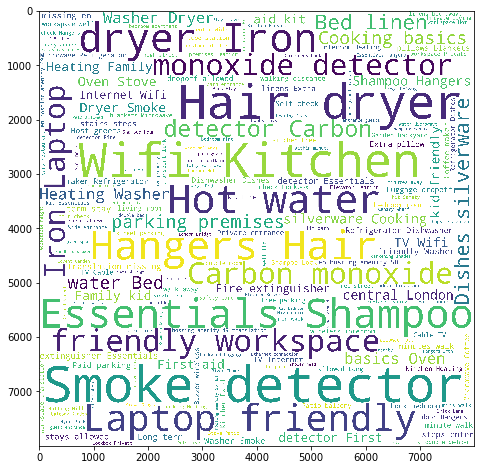

In [324]:
import matplotlib as mpl
#mpl.pyplot(figsize=(10,8))
mpl.pyplot.figure(figsize=(15,8))
mpl.pyplot.imshow(wordcloud)